In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention,
    Softmax, Reshape,Conv2DTranspose, Conv2D, Concatenate
)
from tensorflow.keras.initializers import TruncatedNormal
from einops import rearrange

In [ ]:
pip install tensorflow==2.12

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 585.9/585.9 MB 220.6 MB/s eta 0:00:0100:01

In [3]:
#os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
print(tf.__version__)

2.17.0


In [4]:
path = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset'

In [5]:
data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (128, 128), batch_size = 6000, shuffle = False)

Found 5682 files belonging to 2 classes.


In [6]:
for images, masks in data:
    X = images.numpy().astype("uint8")
    y = masks.numpy().astype("uint8")

print(X.shape, y.shape)

(5682, 128, 128, 3) (5682,)


In [7]:
images = X[y == 0]
masks = X[y == 1]

print(images.shape, masks.shape)

(2841, 128, 128, 3) (2841, 128, 128, 3)


In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(images, masks, test_size = 0.2, random_state = 3)

print(X_train.shape, X_test.shape)

(2272, 128, 128, 3) (569, 128, 128, 3)


In [9]:
# Convert masks to single channel (binary)
y_train = (y_train[..., 0] > 0).astype("uint8")  # Assuming the first channel represents the mask
y_test = (y_test[..., 0] > 0).astype("uint8")
print(y_train.shape, y_test.shape)
# Reshape your target arrays to match the model's output shape
y_train = y_train.reshape((-1, 128, 128, 1))
y_test = y_test.reshape((-1, 128, 128, 1))

print(y_train.shape, y_test.shape)

(2272, 128, 128) (569, 128, 128)
(2272, 128, 128, 1) (569, 128, 128, 1)


In [10]:
def plot_images(X_test, y_test, model_mask, selected_indices):
    for i in selected_indices:
        plt.figure(figsize=(15,5))

        # orignal image
        plt.subplot(1,4,1)
        plt.imshow(X_test[i].squeeze())
        plt.title("Orignal Image")
        plt.axis("off")

        # Orignal Mask
        plt.subplot(1,4,2)
        plt.imshow(y_test[i].squeeze(), cmap='viridis')
        plt.title('Orignal Mask')
        plt.axis("off")

        # Model Mask
        plt.subplot(1,4,3)
        plt.imshow(model_mask[i].squeeze(), cmap='viridis')
        plt.title('Model Mask')
        plt.axis("off")
    plt.show()

In [11]:
def plot_training_history(history, title):
    # Check if `history` is a dictionary and adapt
    if isinstance(history, dict):
        acc = history['accuracy']
        val_acc = history['val_accuracy']
        loss = history['loss']
        val_loss = history['val_loss']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt

# **Transformer layers**

### Patch Partition Layer

The first component of the Swin-T architecture is a Path Parition layer which is used to partition an input image into multiple small patches.

In TensorFlow, we can simply use the [tf.image.extract_patches](https://www.tensorflow.org/api_docs/python/tf/image/extract_patches) function to extract patches. We can use it inside a custom Layer to make it easy to use later when building the model

In [12]:
class PatchPartition(Layer):
    def __init__(self, window_size, channles=3):
        super(PatchPartition, self).__init__()
        self.window_size = window_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.window_size, self.window_size, 1],
            strides=[1, self.window_size, self.window_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [67]:
batch = X_train
window = 4
patches = PatchPartition(window)(batch)
patches.shape

TensorShape([2272, 1024, 48])

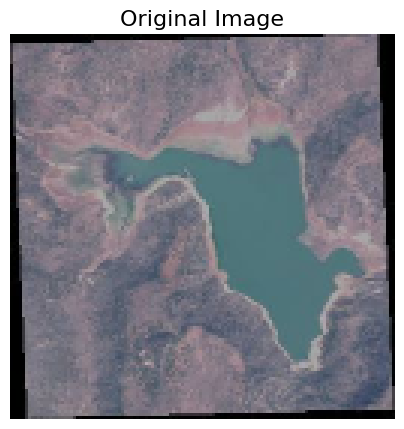

In [25]:
plt.figure(figsize=(5, 5))
plt.imshow(X_train[0].astype("uint8"))
plt.title("Original Image", fontsize=16)
plt.axis("off")
plt.show()

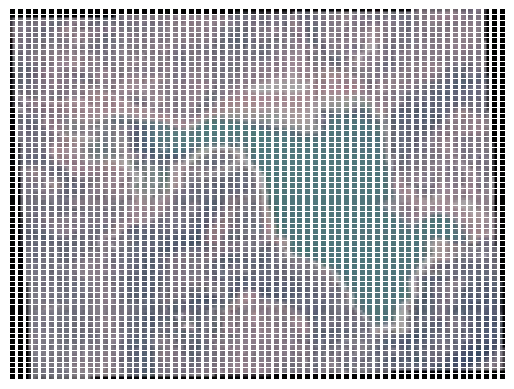

In [28]:
n = int(np.sqrt(patches.shape[1]))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (window, window, 3))
    ax.imshow(patch_img.numpy().astype("uint8"))
    ax.axis("off")

### Linear Embedding layer
The second component in the Swin-T architecture is the Linear Embedding layer which is simply a combination of projection and embedding layers. It is used to calculate the patch embedding and the position embedding then add both as illustrated with the following diagram

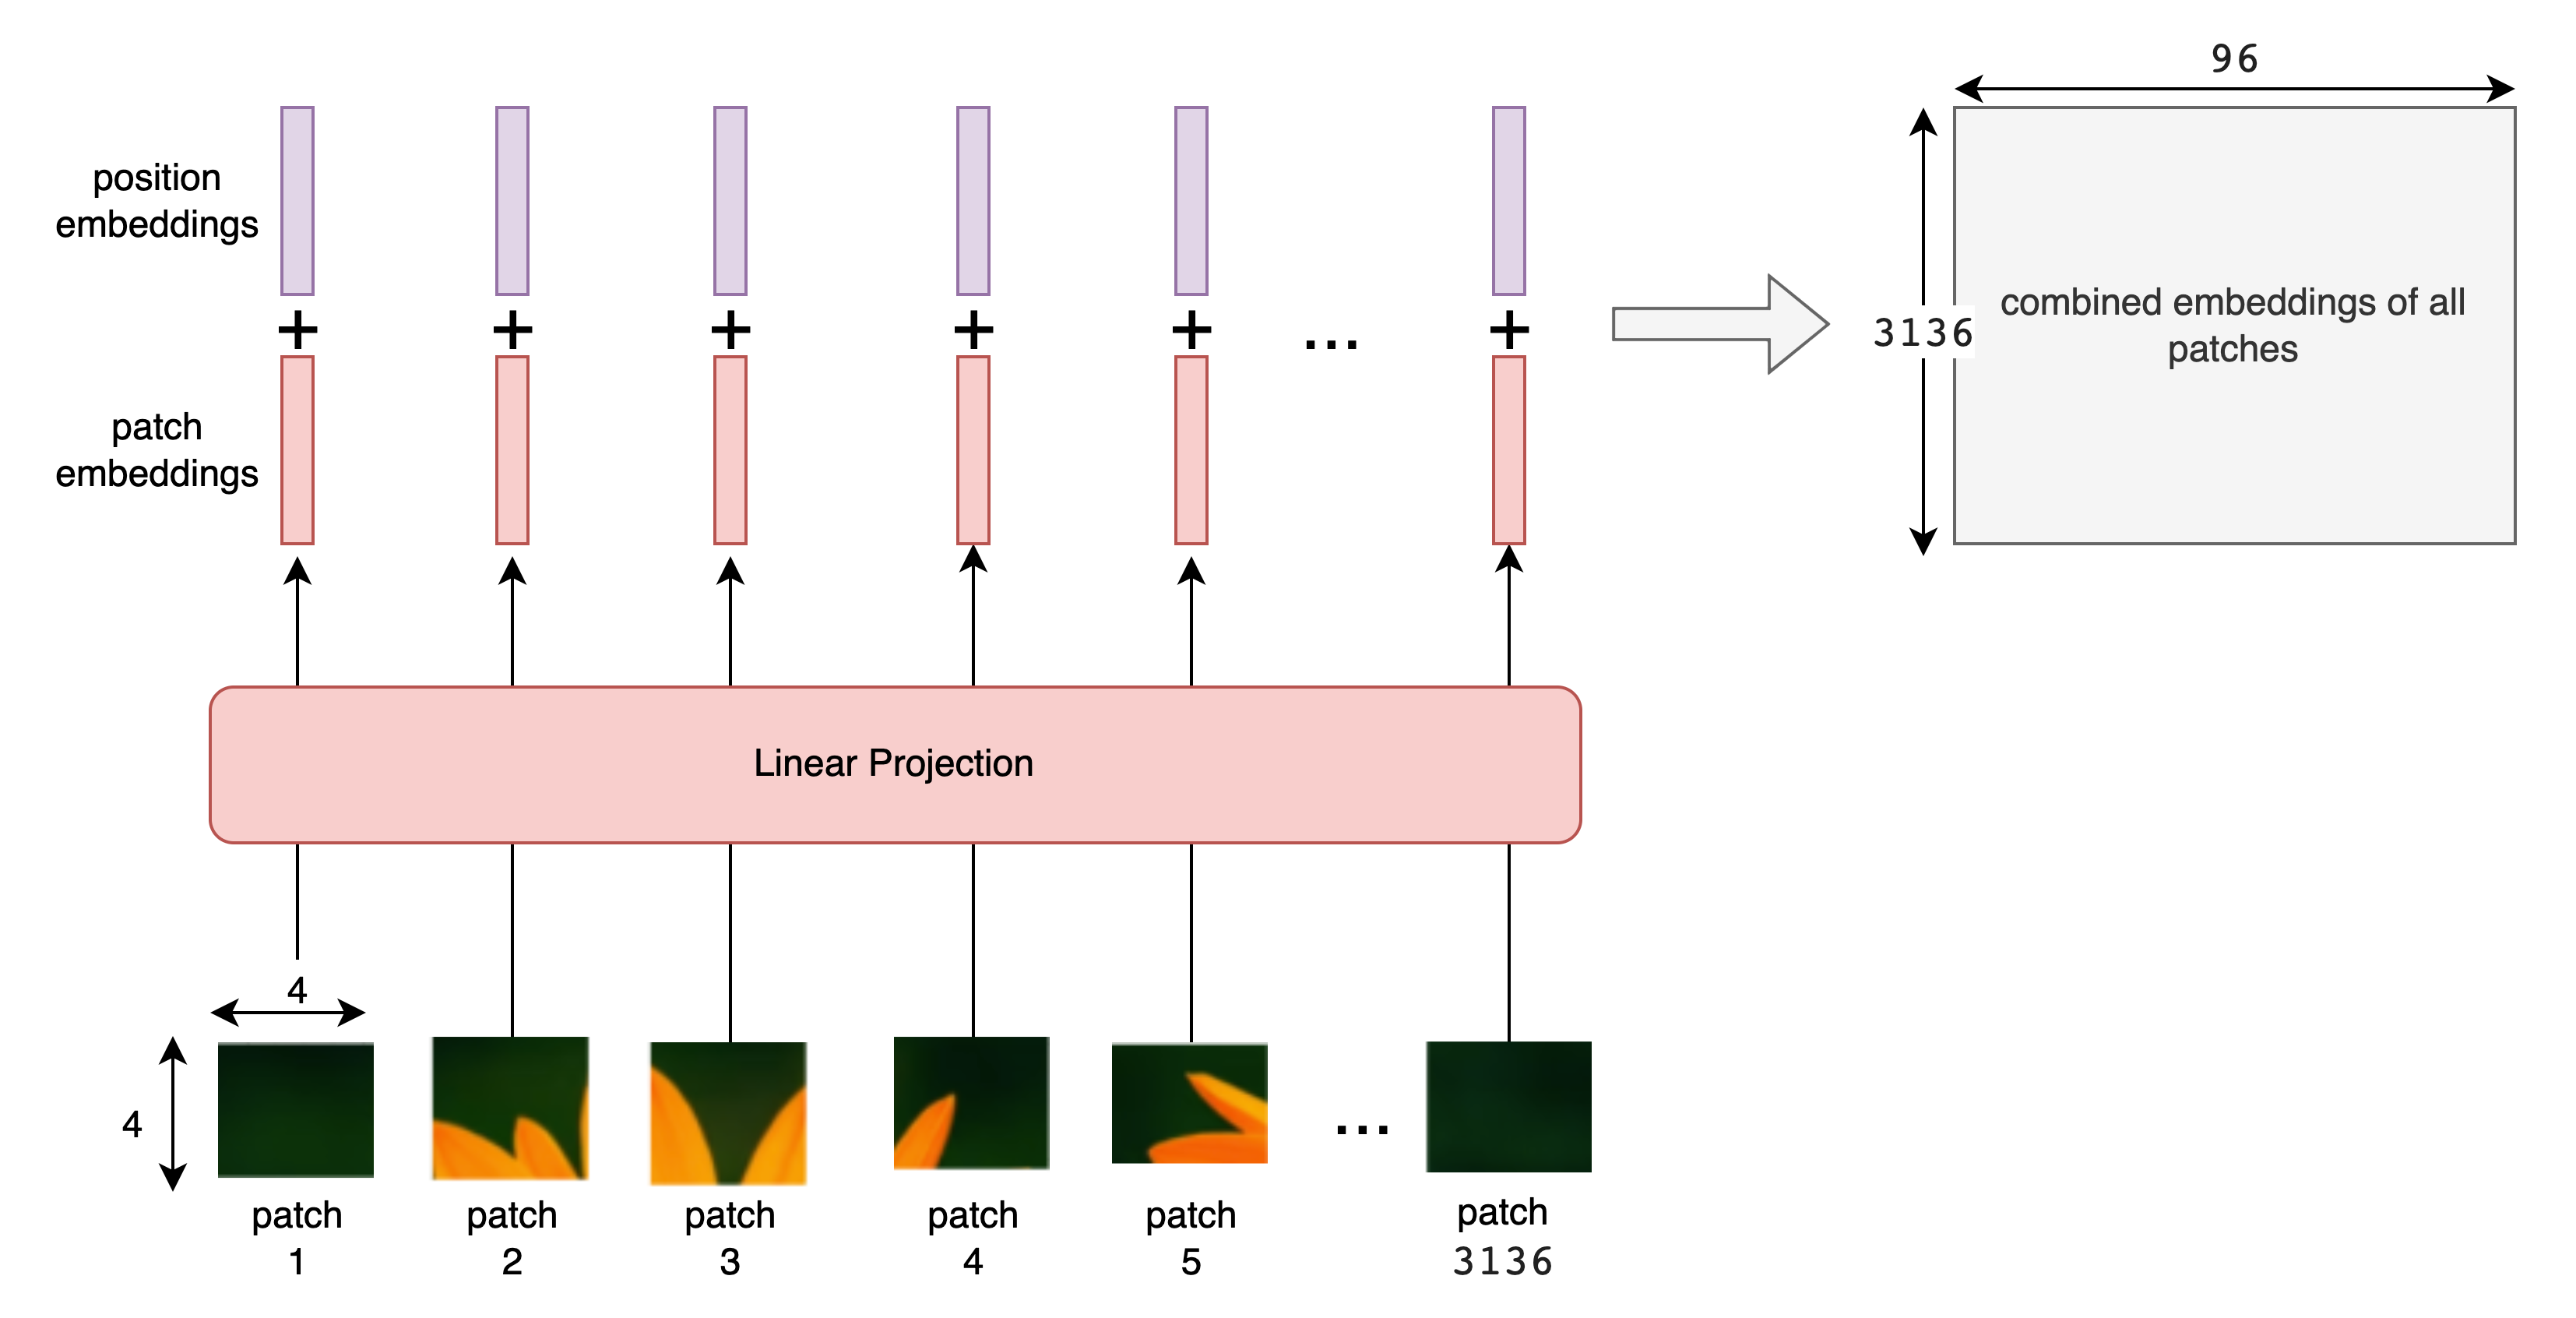

In [68]:
class LinearEmbedding(Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(LinearEmbedding, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = Dense(projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        # calculate patches embeddings
        patches_embed = self.projection(patch)
        # calcualte positional embeddings
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        positions_embed = self.position_embedding(positions)
        # add both embeddings
        encoded = patches_embed + positions_embed
        return encoded

We can confirm that the output of this layer is as expected `2272, 1024, 96`. Here 96 is `projection dimension`

`num_patches = image_height/window_size * image_width/window_size = 128/4 * 128/4 = 1024`

In [70]:
data = (patches.shape[1], patches.shape[2])
print(data)
embeddings = LinearEmbedding(1024, 48)(patches)
embeddings.shape

(1024, 48)


TensorShape([2272, 1024, 48])

### Patch Merging layer
Patch merging as it may indicate is used to merge smaller patches into larger ones. Let's look at the illustration to understand what this layer is doing, if the input of the layer is an `8 x 8` pixel image with 4 patches of `4 x 4` then the output becomes an `8 x 8` pixels but with one large patch of `8 x 8` plus an additional channel layer as channel layers are doubled.

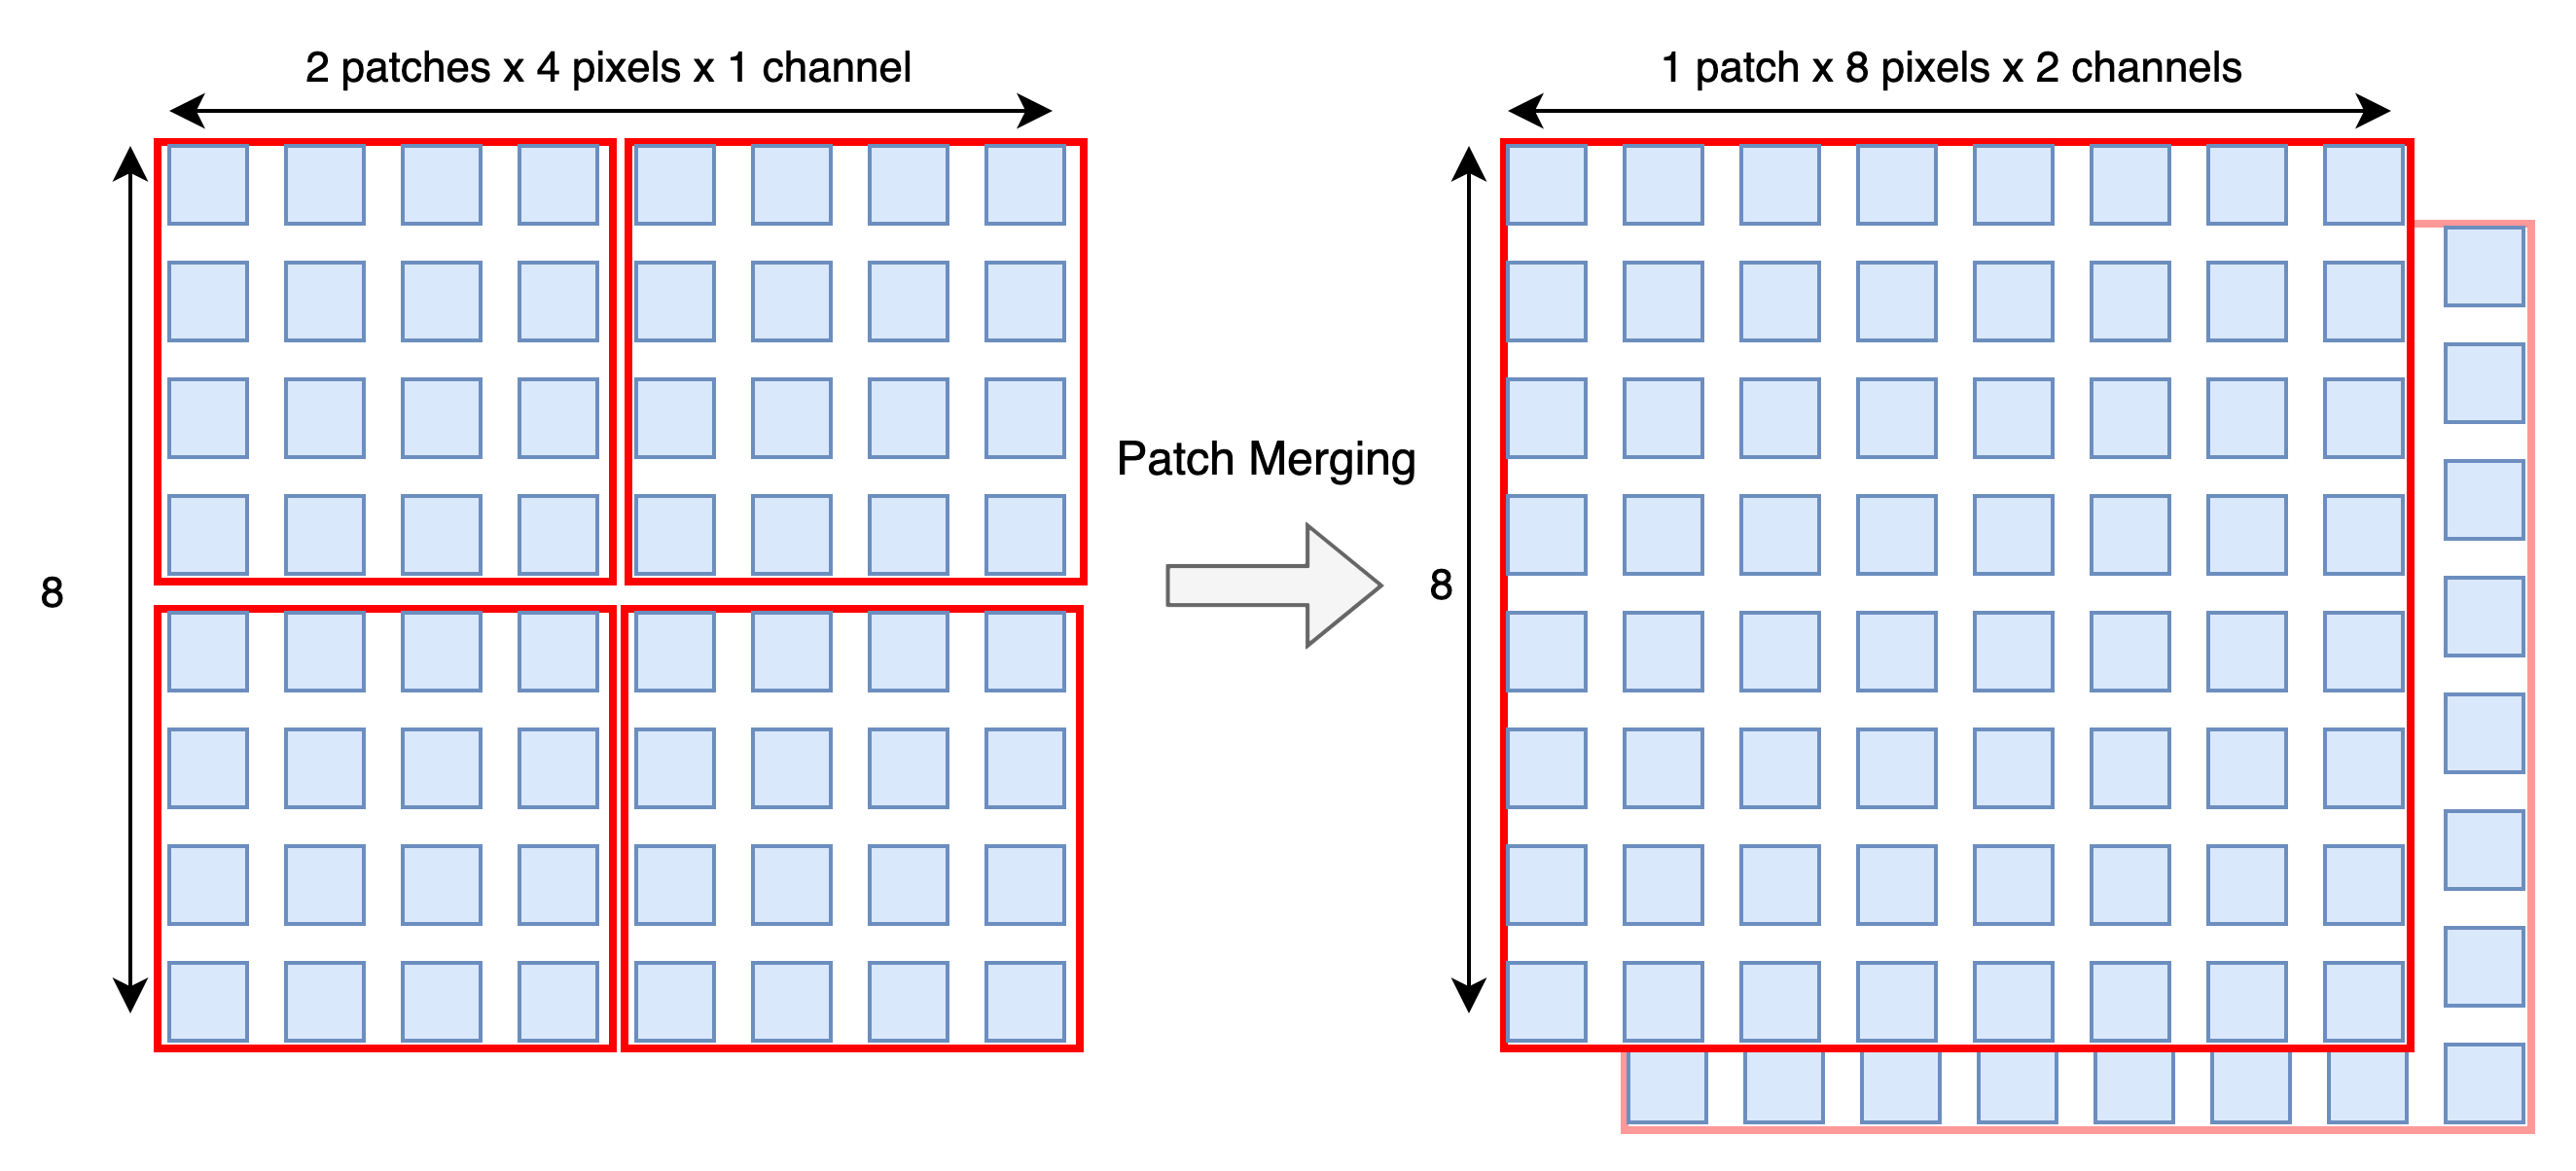

This layer can be simply implemented as a linear layer so that we can easily define the size of the output and double the channels as follows:

In [40]:
class PatchMerging(Layer):
    def __init__(self, input_resolution, channels):
        super(PatchMerging, self).__init__()
        self.input_resolution = input_resolution
        self.channels = channels
        self.linear_trans = Dense(2 * channels, use_bias=False)

    def call(self, x):
        height, width = self.input_resolution
        _, _, C = x.get_shape().as_list()

        # Reshape into 2D grid
        x = tf.reshape(x, shape=(-1, height, width, C))

        # Split into 4 patches
        x0 = x[:, 0::2, 0::2, :] # Top-left
        x1 = x[:, 1::2, 0::2, :] # Bottom-left
        x2 = x[:, 0::2, 1::2, :] # Top-right
        x3 = x[:, 1::2, 1::2, :] # Bottom-right

        # Concatenate along the channel dimension
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        
        # Reshape to a flattened grid and apply linear transformation
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        
        return self.linear_trans(x) 

In [41]:
channels = 1024
num_patch_x = 4  
num_patch_y = 4
out_patches = PatchMerging((num_patch_x, num_patch_y), channels)(patches)
print(f'Input shape (B,   H * W,  C) = {patches.shape}')
print(f'Ouput shape (B, H/2*W/2, 4C) = {out_patches.shape}')

Input shape (B,   H * W,  C) = (32, 1024, 48)
Ouput shape (B, H/2*W/2, 4C) = (2048, 4, 2048)


### Patch Expanding Layer

Patch Expanding Layer is the reverse operation of patch merging. It is used to expand larger patches into smaller ones. This layer increases the spatial resolution of the input image while reducing the number of channels.

If the input of the patch expanding layer is an image of size `8 x 8` pixels with `4` patches of size `8 x 8` (i.e., a larger patch), the output would be an `8 x 8` image, but with multiple smaller patches (e.g., `4 x 4` patches). Additionally, the number of channels would be reduced.

In [51]:
class PatchUnmerging(Layer):
    def __init__(self, target_resolution, channels):
        super(PatchUnmerging, self).__init__()
        self.target_resolution = target_resolution
        self.channels = channels
        self.linear_trans1 = Conv2D(2*channels, kernel_size=1, use_bias=False)

    def call(self, x):
        height, width = self.target_resolution
        B, H, W, C = x.shape # Correct unpacking for 4D tensor

        assert (H == W), 'input feature has wrong size'

        # Apply the 1x1 convolution
        x = self.linear_trans1(x)

        # Rearrange depth to number of patches using depth_to_space
        x = tf.nn.depth_to_space(x, 2, data_format='NHWC')

        # Optionally, convert aligned patches to patch sequence (if required)
        if hasattr(self, 'return_vector') and self.return_vector:
            x = tf.reshape(x, (-1, H * W, C // 4))

        return x


In [52]:
out_patches = tf.keras.layers.Reshape((num_patch_x//2, num_patch_y//2, channels*2))(out_patches)
print(out_patches.shape)
target_resolution = (4, 4)

patch_unmerging = PatchUnmerging(target_resolution, out_patches.shape[3])
output_tensor = patch_unmerging(out_patches)
print("Input shape:", out_patches.shape)
print("Output shape:", output_tensor.shape)

(2048, 2, 2, 2048)
Input shape: (2048, 2, 2, 2048)
Output shape: (2048, 4, 4, 1024)


### Swin Transfomer block
The Swin Transformer block combines two Transofmer Encoder blocks but uses a window based self-attentions as illustrated in the following diagram. In this section, we will examine each component of this bloc and implement it in TensorFlow

> Note: W-MSA stands for Window Multi-head Self-Attention and SW-MSA stands for Shifted Window Multi-head Self-Attention.

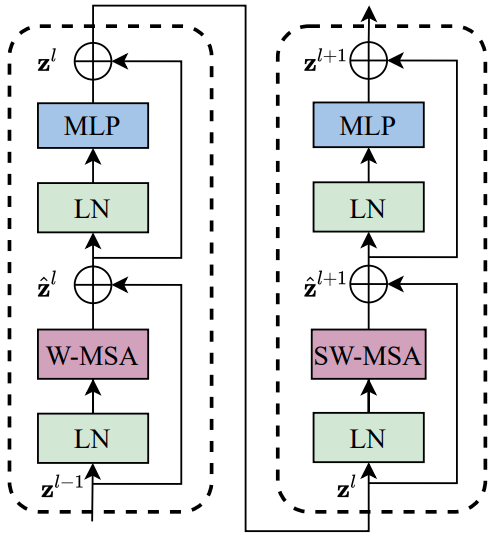

#### Multilayer Perceptron
A Multilayer Perceptron (MLP) consists basically two dense layers and a GELU activation layer. It is used in the classical Transformer architecture and it is also used in the Swin Transformer blocks. We can simply implement it as custom layer as follows:

In [31]:
class MLP(Layer):
    def __init__(self, hidden_features, out_features, dropout_rate=0.1):
        super(MLP, self).__init__()
        self.dense1 = Dense(hidden_features, activation=tf.nn.gelu)
        self.dense2 = Dense(out_features)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        y = self.dropout(x)
        return y

In [166]:
mlp = MLP(768 * 2, 768)
y = mlp(tf.zeros((1, 197, 768)))
y.shape

TensorShape([1, 197, 768])

#### Window multi-head self-attention
The following implementaiton support boths of shifted and non-shifted window attention.

In [32]:
class WindowAttention(Layer):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        initializer = TruncatedNormal(mean=0., stddev=.02)
        # position table shape is: (2*Wh-1 * 2*Ww-1, nH)
        table_shape = ((2*self.window_size[0]-1) * (2*self.window_size[1]-1), num_heads)
        self.relative_position_bias_table = tf.Variable(initializer(shape=table_shape))

        # get pair-wise relative position index for each token inside the window
        coords_h = tf.range(self.window_size[0])
        coords_w = tf.range(self.window_size[1])
        coords = tf.stack(tf.meshgrid(coords_h, coords_w))  # 2, Wh, Ww
        coords_flatten = tf.reshape(coords, [2, -1])  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = tf.transpose(relative_coords, perm=[1,2,0]) # Wh*Ww, Wh*Ww, 2
        relative_coords = relative_coords + [self.window_size[0] - 1, self.window_size[1] - 1]  # shift to start from 0
        relative_coords = relative_coords * [2*self.window_size[1] - 1, 1]
        self.relative_position_index = tf.math.reduce_sum(relative_coords,-1)  # Wh*Ww, Wh*Ww

        self.qkv = Dense(dim * 3, use_bias=qkv_bias, kernel_initializer=initializer)
        self.attn_drop = Dropout(attn_drop)
        self.proj = Dense(dim, kernel_initializer=initializer)
        self.proj_drop = Dropout(proj_drop)
        self.softmax = Softmax(axis=-1)

    def call(self, x, mask=None):
        _, L, N, C = x.shape
        qkv = tf.transpose(tf.reshape(self.qkv(x), [-1, N, 3, self.num_heads, C // self.num_heads]), perm=[2, 0, 3, 1, 4]) # [3, B_, num_head, Ww*Wh, C//num_head]
        q, k, v = tf.unstack(qkv)  # make torchscript happy (cannot use tensor as tuple)
        q = q * self.scale
        attn = tf.einsum('...ij,...kj->...ik', q, k)
        relative_position_bias = tf.reshape(tf.gather(self.relative_position_bias_table, tf.reshape(self.relative_position_index, [-1])),
            [self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1])  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = tf.transpose(relative_position_bias, perm=[2, 0, 1])  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias

        if mask is not None:
            nW = mask.shape[0] # every window has different mask [nW, N, N]
            attn = tf.reshape(attn, [-1 // nW, nW, self.num_heads, N, N]) + mask[:, None, :, :] # add mask: make each component -inf or just leave it
            attn = tf.reshape(attn, [-1, self.num_heads, N, N])
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = tf.reshape(tf.transpose(attn @ v, perm=[0, 2, 1, 3]), [-1, L, N, C])
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [21]:
attn = WindowAttention(96, window_size=(4, 4), num_heads=8, qkv_bias=True, qk_scale=None, attn_drop=0.0, proj_drop=0.0)
y = attn(tf.zeros((1, 196, 16, 96)))
y.shape

TensorShape([1, 196, 16, 96])

#### Helper functions
Before defining the Swin Transformer block, we need couple helper functions to create create windows and merge them.


First, `window_partition` which as the name suggest create windows from the input tensor

In [33]:
def window_partition(x, window_size):
    _, H, W, C = x.shape
    num_patch_y = H // window_size
    num_patch_x = W // window_size
    x = tf.reshape(x, [-1, num_patch_y, window_size, num_patch_x, window_size, C])
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])
    windows = tf.reshape(x, [-1, num_patch_x * num_patch_y, window_size, window_size, C])
    return windows

In [25]:
windows = window_partition(batch, 4)
print(f'Input shape (B,   H,  W,  C) = {batch.shape}')
print(f'Ouput shape (num_windows*B, window_size, window_size, C) = {windows.shape}')

Input shape (B,   H,  W,  C) = (2272, 128, 128, 3)
Ouput shape (num_windows*B, window_size, window_size, C) = (2272, 1024, 4, 4, 3)


Second, `window_reverse` which as the name suggest reverse the created windows

In [34]:
def window_reverse(windows, window_size, H, W):
    C = tf.shape(windows)[-1]  # Get the channel dimension
    B = tf.shape(windows)[0]  # Batch size at runtime
    x = tf.reshape(windows, [B, H // window_size, W // window_size, window_size, window_size, C])
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])  # Reorder dimensions
    x = tf.reshape(x, [B, H, W, C])  # Reshape to the original dimensions
    return x


In [20]:
y = window_reverse(windows, 4, 128, 128)
print(f'Input shape (B, num_windows*B, window_size, window_size, C) = {windows.shape}')
print(f'Ouput shape (B,   H,  W,  C) = {y.shape}')

Input shape (B, num_windows*B, window_size, window_size, C) = (2272, 1024, 4, 4, 3)
Ouput shape (B,   H,  W,  C) = (2272, 128, 128, 3)


In [35]:
class DropPath(Layer):
    def __init__(self, prob):
        super().__init__()
        self.drop_prob = prob

    def call(self, x, training=None):
        if self.drop_prob == 0. or not training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = tf.random.uniform(shape=shape)
        random_tensor = tf.where(random_tensor < keep_prob, 1, 0)
        output = x / keep_prob * random_tensor
        return output

In [21]:
drop = DropPath(0.2)
y = drop(tf.zeros((1, 197, 768)))
y.shape

TensorShape([1, 197, 768])

### SwinTransformerBlock
With the shifted window partitioning approach, consecutive Swin Transformer blocks are computed as

In [89]:
class SwinTransformerBlock(Layer):

    def __init__(self, dim, input_resolution, num_heads, window_size, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim, window_size=(self.window_size, self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else tf.identity
        self.norm2 = LayerNormalization(epsilon=1e-5)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(mlp_hidden_dim, dim, dropout_rate=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = np.zeros([1, H, W, 1])  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            img_mask = tf.constant(img_mask)
            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = tf.reshape(mask_windows, [-1, self.window_size * self.window_size])
            attn_mask = mask_windows[:, None, :] - mask_windows[:, :, None]
            self.attn_mask = tf.where(attn_mask==0, -100., 0.)
        else:
            self.attn_mask = None

    def call(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = tf.reshape(x, [-1, H, W, C])

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = tf.roll(x, shift=[-self.shift_size, -self.shift_size], axis=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = tf.reshape(x_windows, [-1, x_windows.shape[1], self.window_size * self.window_size, C])  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = tf.reshape(attn_windows, [-1, x_windows.shape[1], self.window_size, self.window_size, C])
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = tf.roll(shifted_x, shift=[self.shift_size, self.shift_size], axis=(1, 2))
        else:
            x = shifted_x
        x = tf.reshape(x, [-1, H * W, C])

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


In [90]:
print(embeddings.shape)
block = SwinTransformerBlock(48, (32, 32), 8, window_size=2) # 32 is square root of num_patches which is 1024
y = block(embeddings[:8])
y.shape

(2272, 1024, 48)


TensorShape([8, 1024, 48])

In [823]:
p = PatchMerging((64, 64), channels=12)(y)
p.shape

TensorShape([8, 1024, 24])

## Putting it together
After defining all the major components of the Swin-T architecture, we can put them together to build the model. This is fairly straightforward now as we just need to plug a window partition to an blocks of Swin Transformers separated by a merging layer. For classification, we add a pooling then a dense layer to the form the head of the model.


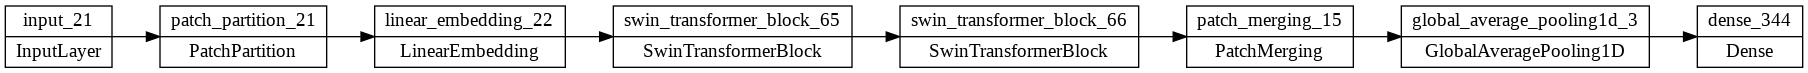


In [105]:
def swin_stack(x, dim, input_resolution, num_heads, window_size, shift_size = True):
    if shift_size:
        shift_size = window_size // 2
    else:
        shift_size = 0
    for i in range(2):
        if i % 2 == 0:
            shift_size_temp = 0
        else:
            shift_size_temp = shift_size
            
        x = swin_stack(x,
                dim=dim,
                input_resolution=input_resolution,
                num_heads=num_heads,
                window_size=window_size,
                shift_size= shift_size_temp
            )(x)
    return x

In [106]:
def create_SwinTransformer(
    num_classes, 
    input_shape=(128, 128, 3), 
    window_size=[4, 2, 2, 2], 
    embed_dim=128, 
    num_heads=[4, 8, 8, 8], 
    num_layers=4,
    patch_size = 4,
    shift_size = True
):
    num_patch_x = input_shape[0] // patch_size
    num_patch_y = input_shape[1] // patch_size
    inputs = Input(shape=input_shape)
    print(f"Input: {inputs.shape}")
    print(f"X_input_patches: {num_patch_x} \nY_input_patches: {num_patch_y}")

    # Patch extractor
    patches = PatchPartition(patch_size)(inputs)
    print(f"PatchPartition: {patches.shape}")
    x = LinearEmbedding(num_patch_x * num_patch_y, embed_dim)(patches)
    print(f"Linear Embedding after patching: {x.shape} \n")
    
    # Swin Transformer Encoder
    encoders = []  # To store intermediate features for the decoder
    x = swin_stack(x,
            dim=embed_dim,
            input_resolution=(num_patch_x, num_patch_y),
            num_heads=num_heads[0],
            window_size=window_size[0],
            shift_size= shift_size
        )
    encoders.append(x)
    print(f"First Block Output: {x.shape} \n")
    
    # Downsampling blocks
    print("Downsampling Start....!")
    for i in range(num_layers - 1):  # Four stages
        if i == 0:
            print(f"Before passing to second block \nembed_dim  {embed_dim} \nx_patch {num_patch_x}  \ny_patch {num_patch_y} \n")
        x = PatchMerging((num_patch_x, num_patch_y), channels=embed_dim)(x)
        num_patch_x //= 2  # Reduce resolution
        num_patch_y //= 2
        embed_dim *= 2  # Double the embedding dimension
        
        x = swin_stack(x,
            dim=embed_dim,
            input_resolution=(num_patch_x, num_patch_y),
            num_heads=num_heads[i],
            window_size=window_size[i],
            shift_size= shift_size
        )
        encoders.append(x)  # Save features for the decoder  

        print(f"At Stage {i+2} \nembed_dim {embed_dim}, \nx_patch {num_patch_x} \ny_patch is {num_patch_y}")
        print(f"Encoder Output and before unmerge : {x.shape} \n")
        
    encoders = encoders[::-1]
    num_heads = num_heads[::-1]
    window_size = window_size[::-1]

    # upsampling begins at the deepest available tensor
    print("Upsampling start.....!")
    x = encoders[0]
    print(f"Encoder x.shape = {x.shape}, num_patch_x = {num_patch_x},  num_patch_y = {num_patch_y}, patch = {num_patch_y*num_patch_x} and embed_dim = {embed_dim} \n")
    x = tf.keras.layers.Reshape((num_patch_x, num_patch_y, embed_dim))(x)
    # other tensors are preserved for concatenation
    x_decode = encoders[1:]
    depth_decode = len(x_decode)
    
    for i in range(depth_decode):
        if embed_dim % 4 != 0:
            raise ValueError(f"embed_dim ({embed_dim}) must be divisible by 4 for DepthToSpace.")
        x = PatchUnmerging(
            target_resolution=(num_patch_x, num_patch_y),
            channels=embed_dim,
        )(x)
        num_patch_x *= 2  # Reduce resolution
        num_patch_y *= 2
        embed_dim //= 2  # Double the embedding dimension
        
        x_decode_reshaped = tf.keras.layers.Reshape((num_patch_x, num_patch_y, embed_dim))(x_decode[i])
        print(f"x_decode_reshaped = {x_decode_reshaped.shape}")
        
        # Concatenation and linear projection
        x = Concatenate(axis=-1)([x, x_decode_reshaped])
        x = Dense(embed_dim, use_bias=False)(x)
        print(f"Dense output {x.shape}")
        x = tf.keras.layers.Reshape((-1, embed_dim))(x)
        print(f"Dense Reshape {x.shape} \n")
        x = swin_stack(x,
            dim=embed_dim,
            input_resolution=(num_patch_x, num_patch_y),
            num_heads=num_heads[i],
            window_size=window_size[i],
            shift_size= shift_size
        )
        print(x.shape)
        x = tf.keras.layers.Reshape((num_patch_x, num_patch_y, embed_dim))(x)
    print(f"Before last unmerge, the output of SwinTransformerBlock is {x.shape} \n")
    
    # The last expanding layer; it produces full-size feature maps based on the patch size
    # !!! <--- "patch_size[0]" is used; it assumes patch_size = (size, size)
    if embed_dim % 4 != 0:
            raise ValueError(f"embed_dim ({embed_dim}) must be divisible by 4 for DepthToSpace.")
    x = PatchUnmerging(
            target_resolution=(num_patch_x, num_patch_y),
            channels=embed_dim,
    )(x)
    
    print(f"Last Unmerge {x.shape}")
    
    x = tf.keras.layers.Conv2DTranspose(
        filters=embed_dim // 2, 
        kernel_size=(2, 2), 
        strides=(2, 2), 
        padding='same'
    )(x)
    x = tf.keras.layers.Conv2D(1, kernel_size=(1, 1), padding='same')(x)
    x = tf.keras.layers.Activation("sigmoid")(x)
    print(f"Final Output {x.shape}")

    return x


In [107]:
#model = create_SwinTransformer(1)(X_train)
model = create_SwinTransformer(1)
#model.summary()

Input: (None, 128, 128, 3)
X_input_patches: 32 
Y_input_patches: 32
PatchPartition: (None, None, 48)
Linear Embedding after patching: (None, 1024, 128) 



RecursionError: maximum recursion depth exceeded in comparison

In [149]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",  # Use categorical_crossentropy for multi-class
    metrics=["accuracy"],
)

In [150]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.3, patience=4, min_lr=1e-6, verbose=1
)

In [151]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    #batch_size = 20,
    callbacks = [lr_scheduler]
)

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 43s 185ms/step - accuracy: 0.5430 - loss: 6.4092 - val_accuracy: 0.6004 - val_loss: 0.6806 - learning_rate: 0.0010
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.5923 - loss: 0.6716 - val_accuracy: 0.6075 - val_loss: 0.6665 - learning_rate: 0.0010
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5934 - loss: 0.6642 - val_accuracy: 0.6196 - val_loss: 0.6467 - learning_rate: 0.0010
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.6053 - loss: 0.6553 - val_accuracy: 0.6168 - val_loss: 0.6458 - learning_rate: 0.0010
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.6031 - loss: 0.6561 - val_accuracy: 0.6263 - val_loss: 0.6351 - learning_rate: 0.0010
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6170 - loss: 0.6360 - val_accuracy: 0.6285 - val_loss: 0.6515 - learning_rate: 0.0010
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6117 - loss: 0.6470 - val_a

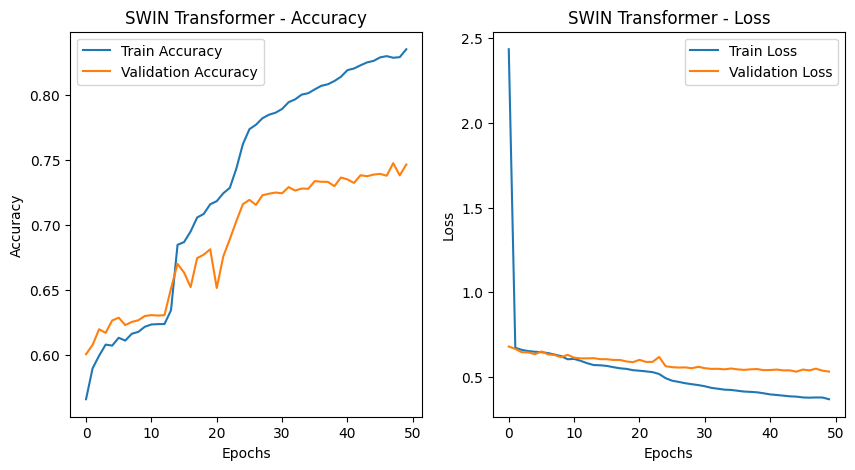

In [152]:
plot_training_history(history, "SWIN Transformer")

In [153]:
swin_mask = model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 289ms/step


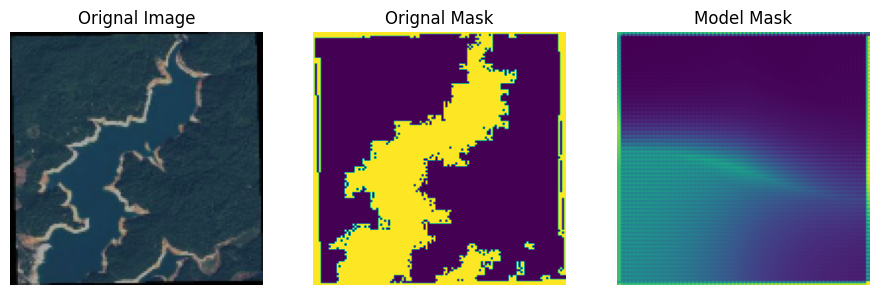

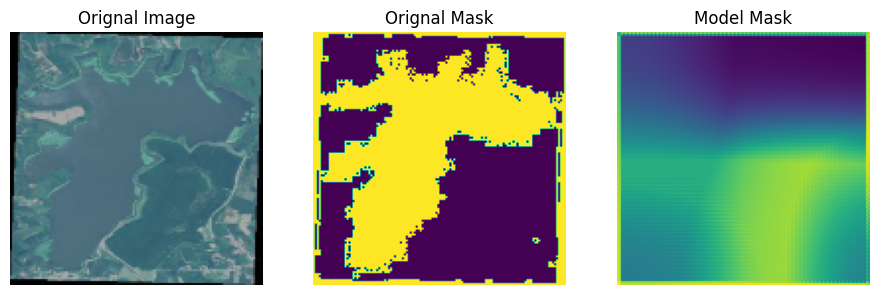

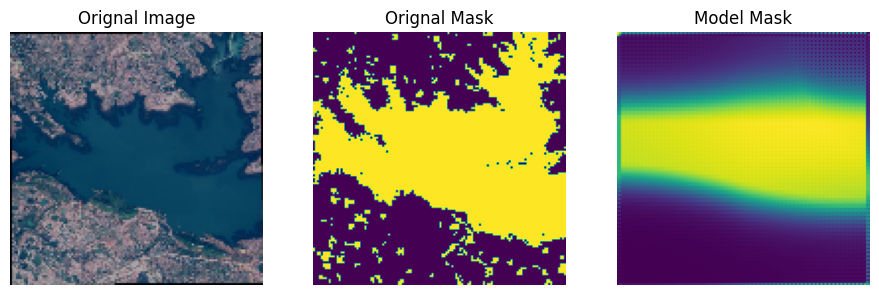

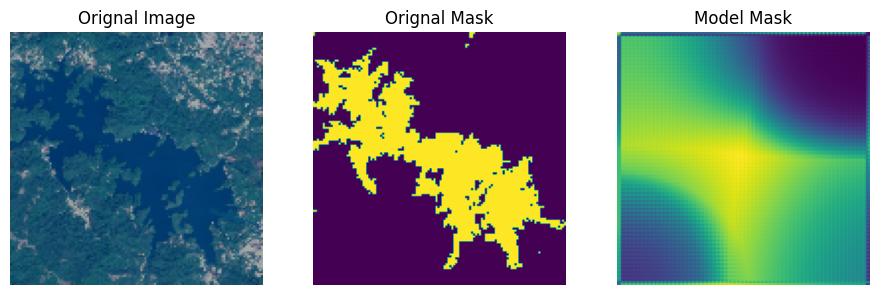

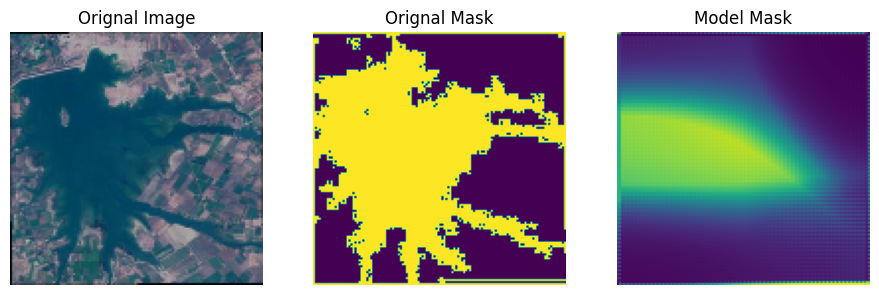

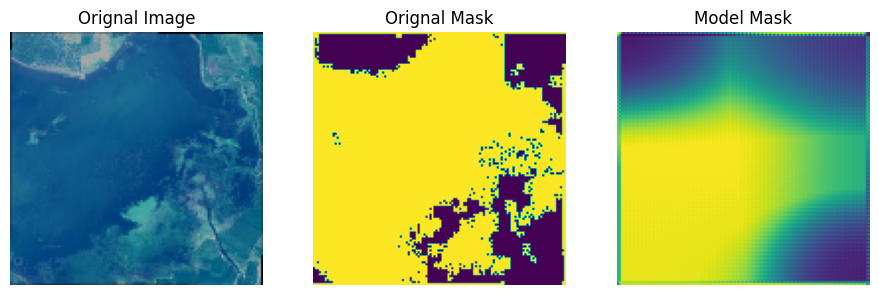

In [154]:
plot_images(X_test, y_test, swin_mask, selected_indices = [1, 4, 22, 25, 46, 95])